# Refiner Tutorial

Welcome to the refiner tutorial.

## Introduction
In this task, we will train a regression to regress the energy of particle physics events (represented by floating point numbers in our toy example). Unfortunately the simulation does not quite fit to the data. Therefore when training the regression on the simulation and evaluating on the data, we will get large biases.

The refiner architecture comes to the rescue.
With a refiner network between the simulation and the regression task, we will make the simulation more data-like.

First we will do all necessary imports:

In [1]:
from functools import partial

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as KTF
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager

## Response
Both our data and the simulation have response functions, how the detector "reacts" to the incident particle energy. Unfortunately our simulation does not yet reflect everything what is going on in the real world. To keep things simple, the reponse in the data only has a constant offset which has not yet been accounted in the simulation. If you want you can also try what the refiner does for more different response functions.

In [2]:
def response_function_data(inp):
    return np.log(inp) + np.pi/10

def response_function_sim(inp):
    return np.log(inp)

## Generate Data
Our incident energies will be floating point numbers between 1 and 2.
We create the dataset and split data and simulation into training and validation data.

In [3]:
energy_data = np.random.rand(150000) + 1
response_data = response_function_data(energy_data)

energy_sim = np.random.rand(150000) + 1
response_sim = response_function_sim(energy_sim)

response_data_train, energy_data_train = response_data[:100000], energy_data[:100000]
response_data_val, energy_data_val = response_data[100000:], energy_data[100000:]

response_sim_train, energy_sim_train = response_sim[:100000], energy_sim[:100000]
response_sim_val, energy_sim_val = response_sim[100000:], energy_sim[100000:]

x_range = np.arange(0, 1, 0.01)

## Data Inspection
Let's inspect our raw data. Knowing that the incident energies in both out data and our simulation are the same we can already see by eye that the modelling of the response of our detector can not be correct.

Text(0, 0.5, 'Energy')

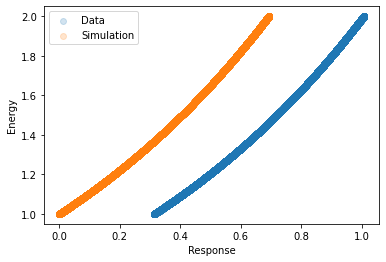

In [4]:
plt.scatter(response_data, energy_data, alpha=0.2, label="Data")
plt.scatter(response_sim, energy_sim, alpha=0.2, label="Simulation")
plt.legend()
plt.xlabel("Response")
plt.ylabel("Energy")

## Train Regression (without Refinement)
Nevertheless we want to infer the energy in our data events. We go ahead and train a regression on the simulation to do this task for us. Using a small DNN and the mean-squared-error as a loss function, our regression converges fast to predict the incident particle energies.

In [5]:
# Train regression on simulation
model = tf.keras.Sequential(
    layers=[
        tf.keras.Input(shape=(1,)),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [6]:
model.fit(response_sim_train, energy_sim_train, batch_size=256, epochs=5)

Train on 100000 samples
Epoch 1/5
   256/100000 [..............................] - ETA: 32s - loss: 2.6359 - mse: 2.6359

2022-07-04 21:27:37.388959: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-04 21:27:37.412910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


100000/100000 [==============================] - 0s 4us/sample - loss: 0.2447 - mse: 0.2447
Epoch 2/5
100000/100000 [==============================] - 0s 3us/sample - loss: 8.9736e-04 - mse: 8.9736e-04
Epoch 3/5
100000/100000 [==============================] - 0s 3us/sample - loss: 7.9187e-04 - mse: 7.9187e-04
Epoch 4/5
100000/100000 [==============================] - 0s 3us/sample - loss: 7.2762e-04 - mse: 7.2762e-04
Epoch 5/5
100000/100000 [==============================] - 0s 3us/sample - loss: 6.7667e-04 - mse: 6.7667e-04


## Inspecting Regression without Refinement
As we can see in the loss, our model well describes the energies in the simulation. However we know that the response function in the data is different. Let's look at how well the network can regress the energy in the data.

/Users/dennis/anaconda3/envs/python3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


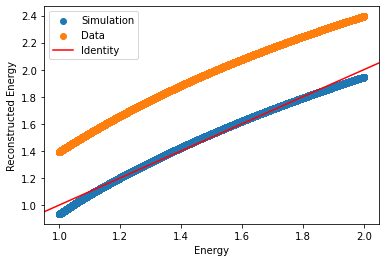

In [7]:
plt.scatter(energy_sim, model.predict(response_sim), label="Simulation")
plt.scatter(energy_data, model.predict(response_data), label="Data")
plt.axline((1, 1), (2, 2), color="r", label="Identity")
plt.xlabel("Energy")
plt.ylabel("Reconstructed Energy")
plt.legend()

Uff that does not look to good. Our model has a large bias when being evaluated on data events.

## Refiner Setup
We will now setup a refiner network to refine the simulation to look more data-like.
We will use two networks (refiner & critic) which are trained in an alternating motion following an adversarial approach.

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def make_trainable(model, trainable):
    """Freezes/unfreezes the weights in the given model"""
    for layer in model.layers:
        layer.trainable = trainable

### Model Setup
We first define the two models.
#### Refiner
The refiner should follow a residual architecture as it should only make small changes to the fiven simulation events. We still know that our simulation, besides being different from the data, will not be totally off.
#### Critic
The critic network does not have to follow a special architecture, however two things are important:
1. We do not want to use layers which employ "dying gradients" (e.g. ReLU) as the critic should be able to forward feedback to the refiner network.
2. We do not want to use an activation in the final layer of the network as the network should be able to regress the Lipschitz-1 functions which are used to infer the Wasserstein loss.

In [9]:
# define two models

def residual_block(x):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Dense(30)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    # Layer 2
    x = tf.keras.layers.Dense(1)(x)
    # Add residual
    x = tf.keras.layers.Add()([x, x_skip])
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

# refiner
refiner_input = layers.Input(shape=(1))
x = residual_block(refiner_input)
x = residual_block(x)
refiner_output = tf.keras.layers.Dense(1)(x)
refiner = Model(refiner_input, refiner_output)

# critic
critic = tf.keras.Sequential(
    layers=[
        tf.keras.Input(shape=(1,)),
        tf.keras.layers.Dense(30, activation=layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.Dense(30, activation=layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.Dense(1),
    ]
)

### Model compilation
The loss functions used in the refiner approach are a little bit more complicated than the loss functions used e.g. DNN driven regressions or classifications. We will define the Wasserstein loss and the gradient penalty in the following.

#### Wasserstein Loss
We use the Kantorovich-Rubinstein duality to approximate the Wasserstein distance.
Using the Wasserstein Distance as a loss, we can compile the Refiner network.

In [10]:
def wasserstein_loss(y_true, y_pred):
    return KTF.mean(y_true * y_pred)

# make trainings model for generator
make_trainable(refiner, True)
make_trainable(critic, False)  # freeze the critic during the generator training

refiner_inp = layers.Input(shape=(1,), name="simulation_ref_training")
refiner_training = Model(refiner_inp, critic(refiner(refiner_inp)))

refiner_training.compile(
    optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0),
    loss=[wasserstein_loss]
)

#### Gradient penalty
The critic has to be a 1-Lipschitz function. To enforce this constrain, we are using the gradient penalty. We will just sample randomly between data events and refined events. At the randomly sampled points we will calculate the gradient of the critic network. We will penalize gradients which are not 1 quadratically. By using the gradient penalty as an additional loss term, our critic will become a Lipschitz-1 constrained function.

In [11]:
class UniformLineSampler(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        weights = KTF.random_uniform((32, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])


# make trainings model for critic
make_trainable(critic, True)  # unfreeze the critic during the critic training
make_trainable(refiner, False)  # freeze the refiner during the critic training

refiner_inp = layers.Input(shape=(1,), name="simulation_critic_training")
critic_inp = layers.Input(shape=(1,), name="data_critic_training")
refiner_out = refiner(refiner_inp)
critic_out_refined = critic(refiner_out)
critic_out_data = critic(critic_inp)

averaged_batch = UniformLineSampler(32)(
    [critic_inp, refiner_out]
)

critic_training = Model(
    inputs=[refiner_inp, critic_inp],
    outputs=[
        critic_out_refined,
        critic_out_data,
        averaged_batch,
    ],
)

def gradient_penalty(y_true, averaged_batch):
    """Calculates the gradient penalty (for details see arXiv:1704.00028v3).
    The 1-Lipschitz constraint for improved WGANs is enforced by adding a term to the loss which penalizes if the gradient norm in the critic unequal to 1"""
    # y_true = dummy values
    # y_pred will be avaraged_batch_out
    with tf.GradientTape() as t:
        t.watch(averaged_batch)
        pred = critic(averaged_batch)
    gradients = t.gradient(pred, averaged_batch)
    gradient_penalty = 0.01 * KTF.square(1 - gradients)
    return KTF.mean(gradient_penalty)
    
gradient_penalty.__name__ = "gradient_penalty"
critic_training.compile(
    optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0),
    loss=[wasserstein_loss, wasserstein_loss, gradient_penalty],
)

### Refiner Training
Using an alternating training schedule we will train the refiner and the critic in the following. Note that the two are encapsulated in different `tf.keras` models in which the correct parts of the models are already frozen. Such we do not need to freeze or unfreeze the refiner and critic parts during the training. We will also plot the critic model during the training process to see how it develops.

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49


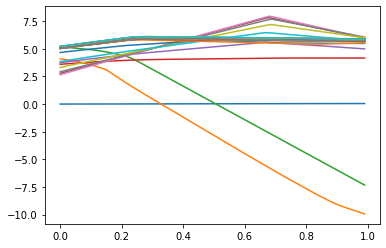

In [12]:
# for wasserstein loss
positive_y = np.ones(32)
negative_y = -positive_y
dummy = np.zeros(32)

# trainings loop
N = 100000
NCR = 2
BATCH_SIZE = 32
iterations_per_epoch = N // ((NCR + 1) * BATCH_SIZE)

refiner_loss = []
critic_loss = []

for epoch in range(50):
    print("epoch: ", epoch)
    plt.plot(x_range, critic.predict(x_range))
    for iteration in range(iterations_per_epoch):
        for j in range(NCR):
            # get simulation data for refiner
            simulation_batch = response_sim_train[BATCH_SIZE * (j + iteration) : BATCH_SIZE * (j + iteration + 1)]
            # get real data
            data_batch = response_data_train[BATCH_SIZE * (j + iteration) : BATCH_SIZE * (j + iteration + 1)]
            
            # train critic
            _critic_loss = critic_training.train_on_batch(
                [simulation_batch, data_batch],
                [negative_y, positive_y, dummy]
            )
            critic_loss.append(_critic_loss)

        # refiner training
        simulation_batch = response_sim_train[BATCH_SIZE * (j + iteration) : BATCH_SIZE * (j + iteration + 1)]
        _refiner_loss = refiner_training.train_on_batch([simulation_batch], [positive_y])
        refiner_loss.append(_refiner_loss)

### Plot Training Critic

The training process of the critic involves the Wasserstein Loss and the Gradients Loss. The loss functions are so noisy because we are not optimizing towards a steady minimum but towards a changing minimum in the form of the discriminator.

Critic and Refiner are competing agains each other in a game-theory-like Minimax game.

Text(0, 0.5, 'Loss')

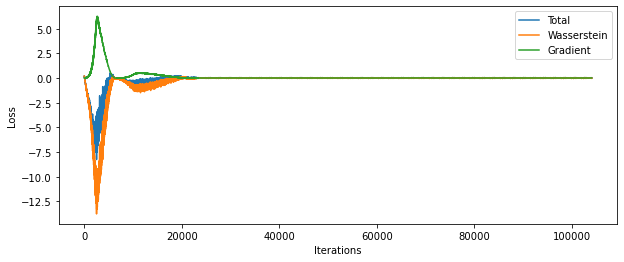

In [13]:
# plot critic loss
fig, ax1 = plt.subplots(1, figsize=(10, 4))
epoch = np.arange(len(critic_loss))
loss = np.array(critic_loss)
plt.plot(epoch, loss[:, 0], label="Total")
plt.plot(epoch, loss[:, 1] + loss[:, 2], label="Wasserstein")
plt.plot(epoch, loss[:, 3], label="Gradient")  
plt.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

### Plot Training Refiner

The training process of the refiner involves the Wasserstein Loss.
Its loss depends on the current state of the critic.

Text(0, 0.5, 'Loss')

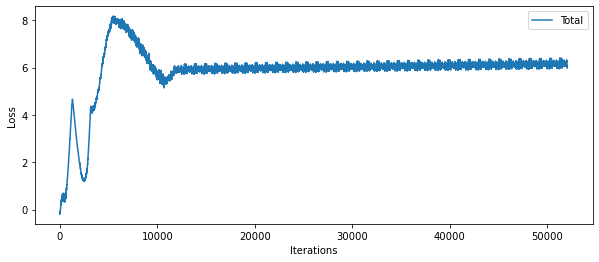

In [14]:
# plot refiner loss
fig, ax1 = plt.subplots(1, figsize=(10, 4))
epoch = np.arange(len(refiner_loss))
loss = np.array(refiner_loss)
plt.plot(epoch, loss, label="Total")
plt.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

## Results

Now that we have trained our refiner network in the adversarial approach, we can look at some results.

We will first plot histograms of the response in the three datasets:
* Recorded data (`data`)
* Generated simulation (`sim`)
* Refined simulation (`refiner.predict(sim)`)

We can see that the overall behaviour of the response in the refined simulation is much more data-like.

/Users/dennis/anaconda3/envs/python3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(array([3682., 3800., 4068., 4459., 4652., 5044., 5387., 5871., 6256.,
        6781.]),
 array([0.3050954 , 0.37197185, 0.43884826, 0.5057247 , 0.57260114,
        0.63947755, 0.706354  , 0.77323043, 0.84010684, 0.9069833 ,
        0.9738597 ], dtype=float32),
 <BarContainer object of 10 artists>)

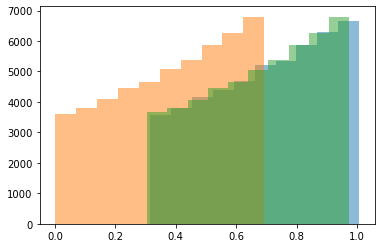

In [15]:
plt.hist(response_data_val, alpha=0.5, label="Data")
plt.hist(response_sim_val, alpha=0.5, label="Simulation")
plt.hist(refiner.predict(response_sim_val), alpha=0.5, label="Refined Simulation")

## Train Regression (with Refinement)
We can now use the refined simulation to train the same regression as bevore on the (refined) data-like simulation.
We will use the same network architecture, optimizer and training parameters as before.

In [16]:
simulation_inp = layers.Input(shape=(1,), name="simulation_inp")
refined_simulation_inp = refiner(simulation_inp)
model = tf.keras.Sequential(
    layers=[
        tf.keras.Input(shape=(1,)),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model_training = Model(
    inputs=simulation_inp,
    outputs=model(refined_simulation_inp),
)


model_training.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [17]:
model_training.fit(response_sim, energy_sim, batch_size=256, epochs=5)

Train on 150000 samples
Epoch 1/5
150000/150000 [==============================] - 1s 5us/sample - loss: 0.0949 - mse: 0.0949
Epoch 2/5
150000/150000 [==============================] - 1s 9us/sample - loss: 6.5109e-04 - mse: 6.5109e-04
Epoch 3/5
150000/150000 [==============================] - 1s 5us/sample - loss: 6.5192e-04 - mse: 6.5192e-04
Epoch 4/5
150000/150000 [==============================] - 1s 5us/sample - loss: 6.5124e-04 - mse: 6.5124e-04
Epoch 5/5
150000/150000 [==============================] - 1s 6us/sample - loss: 6.5224e-04 - mse: 6.5224e-04


We now have our new regressor. We can make the same test as before and evaluate the regression which was trained on the refined simulation of the data events.

We see a success!
The network is now able to nicely infer the energy in the recorded data events.
The bias that we saw before has become much smaller.

Can you train the refinder such that the bias vanishes completely?

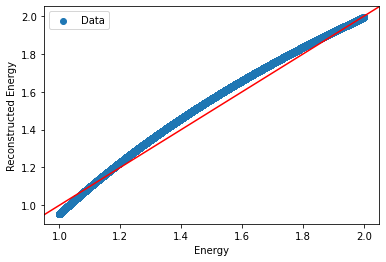

In [18]:
plt.scatter(energy_data_val, model.predict(response_data_val), label="Data")
plt.axline((1, 1), (2, 2), color="r")
plt.xlabel("Energy")
plt.ylabel("Reconstructed Energy")
plt.legend()

## Summary
This concludes our tutorial on the refiner.

You have learned:
* How and why we get a bias when our training data (simulations) does not follow our evaluation data (recorded data)
* What the Wasserstein Distance is and how to implement it
* What the Gradient penalty is and how to implement it
* How we can train a refiner network to mitigate differences between the training and the evaluation data
* How with this refinder network we can solve the problem of insufficient data-simulation modelling when training regression task